In [206]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [207]:
def predict_state(current_state: np.array, input: np.array, state_transition: np.array, input_transition: np.array) -> np.array:
    predicted_state = state_transition @ current_state + input_transition @ input
    return predicted_state

def predict_covariance(covariance: np.array, process_covariance: np.array, state_transition: np.array) -> np.array:
    if covariance.size == 0:
        covariance = process_covariance
    predicted_covariance = state_transition @ covariance @ state_transition.T + process_covariance
    return predicted_covariance

def kalman_filter(state: np.array, covariance: np.array, observation: np.array, position_measure: float, measurement_covariance: float):
    # kalman gain
    K = covariance @ observation.T @ np.linalg.inv(observation @ covariance @ observation.T + measurement_covariance)

    # kalman update
    state = state + K @ (position_measure - observation @ state)

    covariance = (np.eye(2) - K @ observation) @ covariance

    return state, covariance

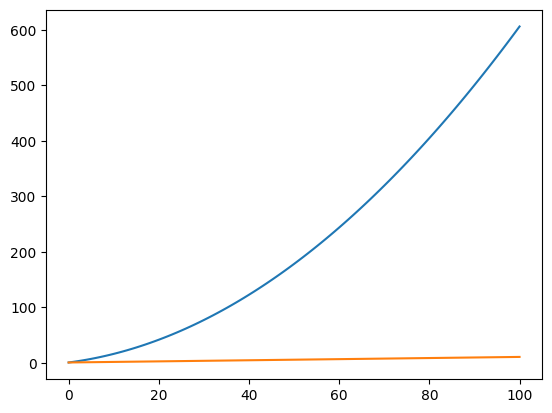

In [208]:
true_state = np.array([[1], [1]]) # state vector (position, velocity)
position_variance = 50 # measurement variance
velocity_variance = 0.001
dt = 1

tracked_true_position = [true_state[0,0]]
tracked_true_velocity = [true_state[1,0]]

for _ in range(100):

    velocity = true_state[1, 0] + 0.1
    position = true_state[0,0] + velocity * dt
    true_state = np.array([[position], [velocity]])

    tracked_true_position.append(position)
    tracked_true_velocity.append(velocity)

plt.plot(tracked_true_position, label='true position')
plt.plot(tracked_true_velocity, label='true velocity')

def measure_velocity(idx: int) -> float:
    return tracked_true_velocity[idx] + np.random.normal(0, velocity_variance)

def measure_position(idx: int) -> float:
    return tracked_true_position[idx] + np.random.normal(0, position_variance)


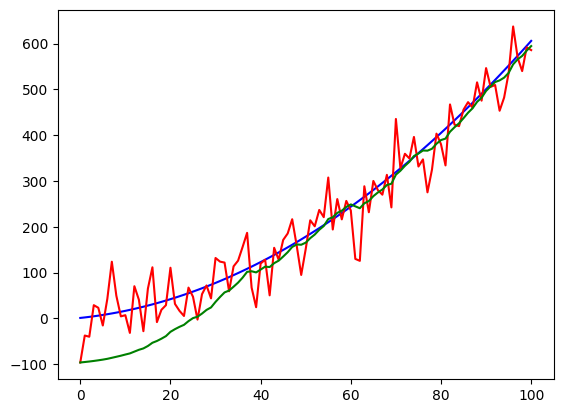

In [209]:
dt = 1 # time step
position_measure = measure_position(0)    # next measured position
velocity_measure = measure_velocity(0)    # next measured velocity


state = np.array([[position_measure],   # state vector (position, velocity)
                  [velocity_measure]]) 

state_transition = np.array([[1, dt],
                             [0, 1]])

input_transition = np.array([[0],
                             [0]])

measurement_variance = position_variance # measurement variance
measurement_covariance = measurement_variance * np.array([[1]])

process_variance = velocity_variance # process variance
process_covariance = process_variance * dt * np.eye(2)

covariance = np.array([[]]) # covariance matrix
observation = np.array([[1, 0]]) # observation matrix


tracked_position = [position_measure]
tracked_position_measure = [position_measure]
tracked_velocity_measure = [velocity_measure]
for idx in range(0, 100):

    # measurements
    velocity_measure = measure_velocity(idx)
    position_measure = measure_position(idx)
    
    state[1][0] = velocity_measure

    state = predict_state(state, np.array([[velocity_measure]]), state_transition, input_transition)
    covariance = predict_covariance(covariance, process_covariance, state_transition)
    
    state, covariance = kalman_filter(state, covariance, observation, position_measure, measurement_covariance)

    tracked_position.append(state[0][0])
    tracked_position_measure.append(position_measure)
    tracked_velocity_measure.append(velocity_measure)


plt.plot(tracked_true_position, 'b')
plt.plot(tracked_position_measure, 'r')
plt.plot(tracked_position, 'g')
